This notebook commpares the new augment and scipy cKDtree with the grid search and brute force based search for single query calculations. 

The objective is to check the benefit of augment coordinates against the periodic wrapper of Bio.KDTree in MDAnalysis. 

In [1]:
import numpy as np
from MDAnalysis.lib._augment import augment_coordinates, undo_augment
from gridlocal import FastNS
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from Bio.KDTree import KDTree
from MDAnalysis.lib.distances import distance_array
from scipy import spatial
import itertools
from tqdm import tqdm_notebook
from collections import defaultdict

In [2]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def pkdt_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def pkdt_query(struct, coords, query, cutoff):
    struct.search(query,cutoff)
    return np.array(struct.get_indices())

In [4]:
def paug_build(box, coords, cutoff):
    aug, mapping = augment_coordinates(coords, box, cutoff)
    all_coords = np.concatenate([coords, aug])
    kdtree = KDTree(dim=3)
    kdtree.set_coords(all_coords)
    return kdtree, mapping
def paug_query(struct, query, cutoff, mapping, nreal):
    struct.search(query,cutoff)
    indices = np.array(struct.get_indices(), dtype=np.int32)
    indices = undo_augment(indices, mapping, nreal)
    return np.sort(indices)

In [5]:
def scaug_build(box, coords, cutoff):
    aug, mapping = augment_coordinates(coords, box, cutoff)
    all_coords = np.concatenate([coords, aug])
    skdtree = spatial.cKDTree(all_coords)
    return skdtree, mapping
def scaug_query(struct, query, cutoff, mapping, nreal):
    indices = np.asarray(struct.query_ball_point(query,cutoff), dtype=np.int32)
    indices = undo_augment(indices, mapping, nreal)
    return np.sort(indices)

Other helper functions

In [6]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

  * check for correctness

In [7]:
#Initialize
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = 100000
points = get_coords(BOX, NPOINTS)

In [8]:
query = np.array([1.,1.,1.], dtype = np.float32)

In [9]:
pkdt = pkdt_build(BOX, points)
indices_pkdt = pkdt_query(pkdt, points, query, CUTOFF)

In [10]:
indices_pkdt 

array([10843, 12477, 16354, 20671, 49081, 50110, 52444, 54027, 59057,
       67654, 72315, 77366, 79953, 80207, 80967, 81450, 83862, 95611])

In [11]:
paug, mapping = paug_build(BOX, points, CUTOFF)

In [12]:
indices_paug = paug_query(paug, query, CUTOFF, mapping, len(points))

In [13]:
indices_paug

array([10843, 12477, 16354, 20671, 49081, 50110, 52444, 54027, 59057,
       67654, 72315, 77366, 79953, 80207, 80967, 81450, 83862, 95611])

In [14]:
saug,  smapping = scaug_build(BOX, points, CUTOFF)

In [15]:
indices_saug = scaug_query(saug, query, CUTOFF, smapping, len(points))

In [16]:
indices_saug

array([10843, 12477, 16354, 20671, 49081, 50110, 52444, 54027, 59057,
       67654, 72315, 77366, 79953, 80207, 80967, 81450, 83862, 95611])

In [17]:
for (a,b) in itertools.combinations([indices_pkdt, indices_paug, indices_saug],2):
    np.testing.assert_array_equal(a, b)

# Benchmark

In [18]:
#initialize
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = 10.
npoints = np.logspace(2,5, num = 10, dtype = np.int)
query = np.array([1.,1.,1.], dtype = np.float32) ## Close to the one of the phases

In [19]:
from tqdm import tqdm_notebook

res_build = defaultdict(list)
res_query = defaultdict(list)
res_total = defaultdict(list)

for N in tqdm_notebook(np.unique(npoints)):
    points = get_coords(box, N)
    
    # Build
    pkdt = pkdt_build(box, points)
    paug, mapping = paug_build(box, points, cutoff)
    saug, smapping = scaug_build(box, points, cutoff)
    
    # Run
    qres = %timeit -q -o pkdt_query(pkdt, points, query, cutoff)
    res_query['pkdtree'].append(qres.average)
    
    bres = %timeit -q -o pkdt_build(box, points)
    res_build['pkdtree'].append(bres.average)
    
    res_total['pkdtree'].append(bres.average + qres.average)
    
    qres = %timeit -q -o paug_query(paug, query, cutoff, mapping, len(points))
    res_query['augment+KDtree'].append(qres.average)
    
    bres = %timeit -q -o paug_build(BOX, points, cutoff)
    res_build['augment+KDtree'].append(bres.average)
    res_total['augment+KDtree'].append(bres.average + qres.average)
    
    
    qres = %timeit -q -o scaug_query(saug, query, cutoff, smapping, len(points))
    res_query['augment+scipy-KDtree'].append(qres.average)
    
    bres = %timeit -q -o scaug_build(BOX, points, cutoff)
    res_build['augment+scipy-KDtree'].append(bres.average)
    res_total['augment+scipy-KDtree'].append(bres.average + qres.average)

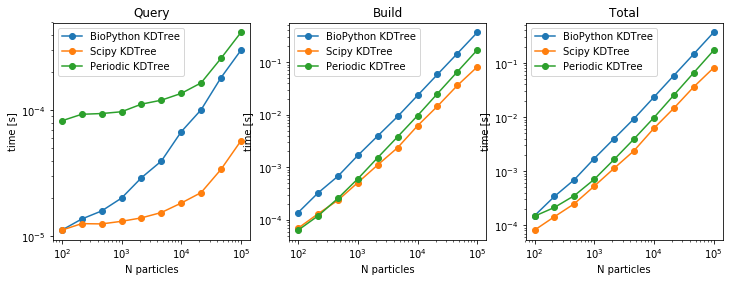

In [20]:
fig, axes = plt.subplots(ncols = 3, figsize = plt.figaspect(1/3))

ax = axes[0]

ax.plot(npoints, res_query['augment+KDtree'], 'o-', label='BioPython KDTree')
ax.plot(npoints, res_query['augment+scipy-KDtree'], 'o-', label='Scipy KDTree')
ax.plot(npoints, res_query['pkdtree'], 'o-', label='Periodic KDTree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.legend()

ax = axes[1]
ax.plot(npoints, res_build['augment+KDtree'], 'o-', label='BioPython KDTree')
ax.plot(npoints, res_build['augment+scipy-KDtree'], 'o-', label='Scipy KDTree')
ax.plot(npoints, res_build['pkdtree'], 'o-', label='Periodic KDTree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[2]
ax.plot(npoints, res_total['augment+KDtree'], 'o-', label='BioPython KDTree')
ax.plot(npoints, res_total['augment+scipy-KDtree'], 'o-', label='Scipy KDTree')
ax.plot(npoints, res_total['pkdtree'], 'o-', label='Periodic KDTree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total')
ax.legend()

It can be clearly seen that there is an significant advantage in query time due to use of cythonized version of augment coordinates. The difference can be seen from the comparison of BioPython KDTree + cythonized augment coordinates and Periodic KDTree. Similarly, advantages of scipy KDTree and augmented coordinates results in almost 10 times faster distance calculations.